##Transferencia de datos

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
#6Minutos
!cp '/gdrive/My Drive/Fotos256.zip' /content/
#!cp "/gdrive/My Drive/Identificacion Maderas CAUCA/EspeciesMaderablesCauca.zip" /content
!rm -r sample_data

In [ ]:
#6Minutos
!unzip -q 'Fotos256.zip'
!rm Fotos256.zip
#!unzip -q "/content/EspeciesMaderablesCauca.zip"
#!rm "/content/EspeciesMaderablesCauca.zip"
!ls Fotos

ls: cannot access 'Fotos': No such file or directory


In [ ]:
!pip   uninstall -y         pillow pil jpeg libtiff libjpeg-turbo
!CC="cc -mavx2" pip install -U --force-reinstall "pillow-simd"

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0
     |████████████████████████████████| 634kB 10.9MB/s 
  Created wheel for pillow-simd: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1117494 sha256=feeb2abece5c34cad6b5cd3d42564313238cd38347ffe170a489959789f4139e
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built pillow-simd


In [ ]:
!mkdir /root/.ssh
!cp "/gdrive/My Drive/keys/"* /root/.ssh
!ssh-keyscan github.com>>/root/.ssh/known_hosts
!chmod 777 /root/.ssh
!eval "$(ssh-agent -s)" && ssh-add "/root/.ssh/id_rsa" && ssh -T git@github.com
!git clone git@github.com:D-A-C-S/maderas.git
  
!git config --global user.email "dacano@unicauca.com"
!git config --global user.name "Colab"

# github.com:22 SSH-2.0-babeld-ffbef2ae
# github.com:22 SSH-2.0-babeld-ffbef2ae
# github.com:22 SSH-2.0-babeld-ffbef2ae
Agent pid 860
Identity added: /root/.ssh/id_rsa (dacano@unicauca.edu.co)
Hi D-A-C-S! You've successfully authenticated, but GitHub does not provide shell access.
Cloning into 'maderas'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 697 (delta 123), reused 237 (delta 97), pack-reused 428
Receiving objects: 100% (697/697), 9.87 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (356/356), done.


##Organizacion de etiquetas

In [ ]:
from maderas.CDataset import EspeciesMaderablesDataset
from maderas.EspeciesMaderables import tabla
import torch
from torchvision import transforms
torch.manual_seed(0)

anotaciones_path = "Fotos256/Anotaciones.csv"
fotos_path = "Fotos256"
#anotaciones_path = "Fotos/Anotaciones.csv"
#fotos_path = "Fotos"

In [ ]:
#from datetime import date
df = tabla.build(anotaciones_path,fotos_path,tiempo_corte=5000)
df = tabla.filter(df,aumento="160X",calidad=2,min_n=500)
#df = df[df.fecha.apply(lambda p:p.date()!=date(2019,8,20))]

train_df,dev_df,test_df = tabla.split(df,[0.7,0.3,0.0],Troncos=True)#seed 0 

Especies seleccionadas: ['Eucalipto blanco', 'Cedro costeño', 'Cuangare', 'Achapo', 'Guayacan amarillo', 'Urapan', 'Chanul', 'Nogal cafetero', 'Sajo']


##Preparacion de datos

In [ ]:
from maderas.AugMix import AM
from maderas.AugMix.aux import CircularMask
import torchvision.transforms as T
RSize= 256
RCrop = 240
JSD = False
augmix_ratio = 0.0
train_transforms = T.Compose([T.RandomResizedCrop(RCrop,scale=(0.8,1.0),ratio=(1.0,1.0)),
                              T.RandomHorizontalFlip(),
                              CircularMask(RCrop),
                              T.RandomRotation(180,2)])

train_dataset = EspeciesMaderablesDataset(train_df,transform=train_transforms)
train_dataset = AM.AugMixDataset(train_dataset,AM.preprocess,jsd=JSD,ratio=augmix_ratio)

dev_dataset = EspeciesMaderablesDataset(dev_df,transform=AM.test_transforms(int(0.9*RSize),RCrop))#


## Modelo

In [ ]:
import torch.nn as nn
torch.manual_seed(1004)
from maderas.EfficientNet import efficientnet_builder
from maderas.EfficientNet import efficientnet_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
NM = 1
modelo = efficientnet_builder.get_model(f"efficientnet-b{NM}",1000,code=None)
pesos = f"/gdrive/My Drive/pymodels/EfficientNet/b{NM}"
#pesos = f"/gdrive/My Drive/pymodels/NoisyEfficientNet/b{NM}"
modelo.load_state_dict(torch.load(pesos)["model_state_dict"])
print("Resolucion de imagen:",efficientnet_builder.efficientnet_params(f"efficientnet-b{NM}")[2],"px")

Resolucion de imagen: 240 px


In [ ]:
N_CLASSES = len(train_df.especie.unique())
modelo._fc = nn.Linear(modelo._fc.in_features,N_CLASSES)#Inicializacion aleatoria
modelo._dropout = nn.Dropout(p=0.6)
#modelo._dropout = nn.Identity()
N_CLASSES

9

In [ ]:
from maderas.Optimizacion import unlock_gradients
modulos_libres = ([modelo._fc,
                  modelo._dropout,modelo._bn1,modelo._conv_head]
                  +list(modelo._blocks[12:]))

#modulos_libres = [modelo]            
parametros_optimizables = unlock_gradients(modelo,modulos_libres)
Nparametros = sum([para.numel() for name,para in modelo.named_parameters() if para.requires_grad])
Nparametros

6070541

## Optimizacion

In [ ]:
from maderas.Optimizacion import train_model,eval_model,freeze_base
from torch.utils.data import DataLoader

In [ ]:
batch_size = 32
drop_last = len(train_dataset)%32<batch_size/2
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True,drop_last=drop_last)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

In [ ]:
#from radam import RAdam
modelo.to(device)
criterion = nn.CrossEntropyLoss()#combina Log(Softmax) con CrossEntropyLoss
#criterion = smooth_cross_entropy
lr = 1E-3
weight_decay = 1E-4
weight_decay/=lr
T0 = len(train_dataset)//batch_size + (not drop_last) #Numero de iteraciones hasta el primer lr restart
T0 = 7*T0
optimizer = torch.optim.AdamW(parametros_optimizables,weight_decay = weight_decay,lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T0,T_mult=2)
#optimizer = torch.optim.RMSprop(parametros_optimizables,lr=0.001,momentum=0.9)
#AdamW: wieght decay(W):update rule: theta = (1-n*lr*W)theta+...
#AdamW segun paper: theta = (1-n*W)theta:n:lrschedulerfactor
#Primera normalizacion W = W/lr#Valores de W:1E-4,1E-3
#Segunda normalizacion propuesta:W = W/sqrt(lotesPorEpoca*NumeroDeEpocasPorCiclo)


In [ ]:
#torch.backends.cudnn.benchmark = True
epochs = 7

train_accs = []
eval_accs = []
train_losses = []
eval_losses = []

for epoch in range(epochs):
  print('epoch {}/{}'.format(epoch+1,epochs))

  freeze_base(modelo,modulos_libres)
  AM.train(modelo,device,train_loader,optimizer,
                                  criterion,scheduler=scheduler,
                                  jsd=JSD,log_data=False)
  train_loss,train_acc = (1,1)
  
  modelo.eval()
  eval_loss,eval_acc = eval_model(modelo,dev_loader,criterion,
                                  device=device)

  train_accs.append(train_acc)
  train_losses.append(train_loss)
  eval_accs.append(eval_acc)
  eval_losses.append(eval_loss)


epoch 1/7
train_loss: 0.317 acc:0.900
eval loss: 0.298 acc:0.915
epoch 2/7
train_loss: 0.109 acc:0.969
eval loss: 0.198 acc:0.946
epoch 3/7
train_loss: 0.070 acc:0.978
eval loss: 0.135 acc:0.956
epoch 4/7
train_loss: 0.049 acc:0.985
eval loss: 0.133 acc:0.962
epoch 5/7
train_loss: 0.028 acc:0.992
eval loss: 0.089 acc:0.972
epoch 6/7
train_loss: 0.021 acc:0.995
eval loss: 0.093 acc:0.972
epoch 7/7
train_loss: 0.017 acc:0.995
eval loss: 0.097 acc:0.970


##Evaluacion

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from seaborn import heatmap
from sklearn.metrics import matthews_corrcoef

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
modelo.to(device)
modelo.eval()
all_labels, all_predictions,indices,all_probas = eval_model(modelo,dev_loader,criterion,test=True,device=device)
ToEspecie = ["Achapo","Cedro costeño","Chanul","Cuangare","Eucalipto blanco",
             "Guayacan amarillo","Nogal cafetero","Sajo","Urapan"]
#print(classification_report(all_labels,all_predictions, target_names=ToEspecie))
score = f1_score(all_labels, all_predictions,average="macro")

eval loss: 0.097 acc:0.970


In [ ]:
from torchvision.transforms.functional import adjust_hue
class HueShift(object):
  def __init__(self,value):
    self.value=value
  def __call__(self,image):
    image = adjust_hue(image,self.value)
    return image

In [ ]:
import numpy as np
all_confidence = np.concatenate(all_probas)
#calibration_error = cal.get_calibration_error(all_confidence,np.array(all_labels))

mcc = matthews_corrcoef(all_labels,all_predictions)
max_probas = np.max(all_confidence,axis=1)
#seg_acc,seg_prob,seg_flag,ece = ECE(max_probas,all_labels,all_predictions,n_bins=10)

print(f"mcc: {mcc:.3f}")
#print(f"Debiased SCE:{100*calibration_error:.3f}")

mcc: 0.962


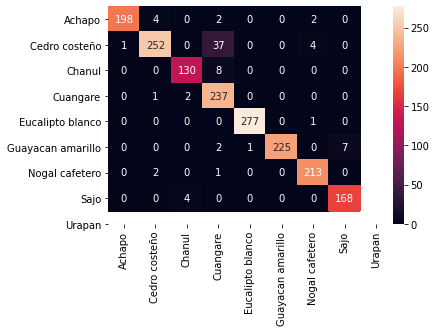

In [ ]:
mat = confusion_matrix(all_labels, all_predictions)
ax = heatmap(mat,xticklabels=ToEspecie,yticklabels=ToEspecie,annot=True,fmt='d')

##Registro

In [ ]:
"""
import pandas as pd
from time import gmtime

columnas = ["modelo","no.parametros","aumento","no.especies","no.imagenes","epochs","criterion","optimizer","descripcion","mcc","score","fecha","codigo"]
#registro_exp = pd.DataFrame(columns=columnas)
registro_exp = pd.read_csv("maderas/Registro_de_optimizaciones.csv")

Nparametros = sum([para.numel() for para in modelo.parameters() if para.requires_grad])

Nmodelo = "EfficientNet B0"
Aumento = "160X"
epocas = 7
Descripcion = "conv8+,no jsd,escala aumentacion 0.8"

Codigo = f'{Nmodelo}_{mcc}'
UCT = gmtime()
fecha = (UCT.tm_year,UCT.tm_mon,UCT.tm_mday,UCT.tm_hour)
registro_exp = registro_exp.append(pd.DataFrame(
    [[Nmodelo,Nparametros,Aumento,N_CLASSES,len(train_dataset),epocas,str(criterion),str(optimizer),Descripcion,mcc,score,fecha,Codigo]],columns=columnas),sort=False)

registro_exp.to_csv("maderas/Registro_de_optimizaciones.csv",index=False)
registro_exp.tail()
"""

**Guardar el documento y ejecutar la siguiente celda**

In [ ]:
!cp "/gdrive/My Drive/Colab Notebooks/P4AugMix.ipynb" maderas/Notebooks
!git -C maderas checkout Experimentos
!git -C maderas add Note* Reg*
!git -C maderas commit -m "Añado registro de experimento"
!git -C maderas push origin Experimentos

**Opcional:Guardar modelo en drive**

In [ ]:
Codigo = "sin_alteraciones_color.pt"
from os.path import join as Pjoin
path = "/gdrive/My Drive/pymodels/maderas"
torch.save({'model_state_dict':modelo.state_dict(),
            'CodToEspecie':ToEspecie},Pjoin(path,Codigo))

In [ ]:
!ls "/gdrive/My Drive/pymodels/maderas"

**Opcional:Guardar modelo:local**

In [ ]:
Codigo = "cp"
from os.path import join as Pjoin
path = "/content"
torch.save({'model_state_dict':modelo.state_dict(),
            'CodToEspecie':ToEspecie},Pjoin(path,Codigo))

In [ ]:
!cp "E0-1284.zip" "/gdrive/My Drive/pymodels/maderas"

**Opcional: Serializar modelo**

In [ ]:
modelo.cpu()
modelo.eval()
path = "/gdrive/My Drive/pymodels/maderas"
Codigo = "B1_02271216"
RCROP = 240
example = torch.randn(1,3,RCROP,RCROP)
traced_script_module = torch.jit.trace(modelo,example)
traced_script_module.save(Pjoin(path,Codigo)+".zip")

In [ ]:
path = "/gdrive/My Drive/pymodels/maderas"
!ls "$path"

B0_3202053.pt		     EfficientNet-b0_0.6220966094804097
B0_3202054.pt		     EfficientNet-b0_0.9287998991823815
B0_exp_global0.pt	     EfficientNet-b0_0.9808278710843827
B0_randinit28Epoch_noaug.pt  EnetCono16
B1_02271216		     EnetCono16+5
B1_02271216.zip		     epoca13_0961.pt
B1_0614_2207.pt		     MD_B1_02271216.onnx
B1_0620_1915.pt		     MD_B1_02271216.zip
Binario_solo_sintetico.pt    randinit_ablation_42epoch.pt
E0-1284.zip		     sin_alteraciones_color.pt
e-1_0.3			     sin_cambio_de_escala_stylized.pt


**Cargar modelo**

In [ ]:
from os.path import join as Pjoin
path = "/gdrive/My Drive/pymodels/maderas"
PATH = Pjoin(path,"B1_0614_2207.pt")
modelo.load_state_dict(torch.load(PATH)["model_state_dict"])#

<All keys matched successfully>

## Vis

In [ ]:
val_path = "/gdrive/My Drive/Identificacion Maderas CAUCA/IMAGENES XILOTECA UNICAUCA/Validacion"

In [ ]:
from torchvision.datasets import ImageFolder
from maderas.Optimizacion import test_model
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
deltas = np.arange(20)/20-0.5
mccs2 = []
for delta_hue in deltas:
  color_transforms = T.Compose([T.Resize(int(1.35*RSize)),
                                T.CenterCrop(RCrop),
                                HueShift(delta_hue),
                                AM.preprocess])

  RCrop = 240
  modelo.eval()
  modelo.to(device)
  #val_dataset = ImageFolder(val_path,transform=AM.test_transforms(int(1.35*RSize),RCrop))
  val_dataset = ImageFolder(val_path,transform=color_transforms)
  val_loader = DataLoader(val_dataset,batch_size=32)
  criterion = nn.CrossEntropyLoss()

  all_labels, all_predictions,all_probas = test_model(modelo,val_loader,criterion,test=True,device=device)
  ToEspecie = ["Achapo","Cedro costeño","Chanul","Cuangare","Eucalipto blanco",
              "Guayacan amarillo","Nogal cafetero","Sajo","Urapan"]
  #print(classification_report(all_labels,all_predictions, target_names=ToEspecie))#
  score = f1_score(all_labels, all_predictions,average="macro")
  mcc = matthews_corrcoef(all_labels,all_predictions)
  mccs2.append(mcc)

eval loss: 0.936 acc:0.708
eval loss: 0.998 acc:0.667
eval loss: 0.988 acc:0.698
eval loss: 1.094 acc:0.708
eval loss: 1.157 acc:0.708
eval loss: 1.158 acc:0.729
eval loss: 1.164 acc:0.760
eval loss: 1.214 acc:0.792
eval loss: 1.115 acc:0.771
eval loss: 0.379 acc:0.885
eval loss: 0.145 acc:0.969
eval loss: 0.334 acc:0.875
eval loss: 0.553 acc:0.823
eval loss: 0.656 acc:0.760
eval loss: 0.739 acc:0.719
eval loss: 0.690 acc:0.750
eval loss: 0.667 acc:0.802
eval loss: 0.683 acc:0.792
eval loss: 0.788 acc:0.792
eval loss: 0.826 acc:0.760


In [ ]:
#import calibration as cal
import numpy as np
from maderas.Indicadores import ECE
all_confidence = np.concatenate(all_probas)
#calibration_error = cal.get_calibration_error(all_confidence,np.array(all_labels))

mcc = matthews_corrcoef(all_labels,all_predictions)
max_probas = np.max(all_confidence,axis=1)
seg_acc,seg_prob,seg_flag,ece = ECE(max_probas,all_labels,all_predictions,n_bins=10)

print(f"mcc: {mcc:.3f}")
#print(f"Debiased SCE:{100*calibration_error:.3f}")

mcc: 0.834


In [ ]:
%%writefile RAdam.sh
git clone https://github.com/LiyuanLucasLiu/RAdam
cd RAdam
pip install .

Writing RAdam.sh


In [ ]:
!. RAdam.sh

Cloning into 'RAdam'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 309 (delta 12), reused 16 (delta 3), pack-reused 274
Receiving objects: 100% (309/309), 954.63 KiB | 2.52 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Processing /content/RAdam
  Created wheel for RAdam: filename=RAdam-0.0.1-cp36-none-any.whl size=7103 sha256=aa3aeafc62eabe3da956a25eca9e7a6b8a5cbe32cfb177648a77760ba4c71722
  Stored in directory: /tmp/pip-ephem-wheel-cache-kl6ta6k4/wheels/7c/46/16/44b5f59926113cc1dc0e9a57b2562ee86ad6c6a0a2edd3e3da
Successfully built RAdam
